# Homework #5 - Ravi Raghavan

In [201]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt

## Theoretical Calculations of Gradient and Hessian

$f(x) = - \sum_{i=1}^{m} \log{(1 - a_i^Tx)} - \sum_{i=1}^{n} \log{(1 - x_i^2)}$

$x \in \mathbb{R}^n$ and $dom f = \{ x | a_i^Tx < 1, i = 1, 2, ..., m, |x_i| < 1, i = 1, 2, ..., n\}$





$\frac{\partial{f}}{\partial{x_j}} = - (\sum_{i=1}^{m} (\frac{1}{1 - a_i^Tx}) (-a_{ij})) - \frac{1}{(1 - x_j^2)} (-2x_j)$

$\frac{\partial{f}}{\partial{x_j}} =  \sum_{i=1}^{m} (\frac{a_{ij}}{1 - a_i^Tx}) + \frac{2x_j}{(1 - x_j^2)}$


$\frac{\partial{f}}{\partial{x_k} \partial{x_j}}$: 

Case where $j = k$:

$\frac{\partial{f}}{\partial{x_k} \partial{x_j}} = \sum_{i=1}^{m} a_{ij} (\frac{-1}{(1 - a_i^Tx)^2}) (-a_{ik}) + \frac{2(1 - x_j^2) - 2x_j(-2x_j)}{(1 - x_j^2)^2}$

$\frac{\partial{f}}{\partial{x_k} \partial{x_j}} = \sum_{i=1}^{m} (\frac{a_{ij} a_{ik}}{(1 - a_i^Tx)^2})  + \frac{2(1 + x_j^2)}{(1 - x_j^2)^2}$

$\frac{\partial{f}}{\partial{x_k} \partial{x_j}} = \sum_{i=1}^{m} (\frac{a_{ij} a_{ik}}{(1 - a_i^Tx)^2})  + \frac{2(1 + x_j^2)}{(1 - x_j^2)^2}$


Case where $j \neq k$: 

$\frac{\partial{f}}{\partial{x_k} \partial{x_j}} = \sum_{i=1}^{m} (\frac{a_{ij} a_{ik}}{(1 - a_i^Tx)^2})$





## Programmatic Implementations of Descent Methods

In [202]:
#Function to Perform Gradient Descent
#f: Compute function value at given point
#gradient: compute gradient of function at given point
#backtracking_algorithm: function used to perform backtracking
#A: matrix of ai vectors where ai are the rows of A
#x0: initial point of gradient descent
#max_iter: maximum number of iterations of Gradient Descent to run 
#eta: used in convergence criteria
#alpha: alpha parameter for backtracking
#beta: beta parameter used for backtracking
def gradient_descent(f, gradient, backtracking_algorithm, A: np.ndarray, x0: np.ndarray, max_iter, eta, alpha, beta):
    #Set initial iterate and function value
    x = x0
    fx = f(A, x)
    
    #maintain arrays to store iterates and function values throughout gradient descent
    points = np.array([x])
    function_values = []
    function_values.append(fx)
    
    #Store alphas
    alphas = []
    
    #enter for loop of max_iter times
    for iter in range(max_iter):
        grad = gradient(A, x) #compute gradient        
        print(f"Iteration: {iter + 1}, Max of A @ x: {np.max(A @ x)}, Max of x^2: {np.max(np.square(x))}, Current Function Value(Beginning of Iteration): {fx}, Norm of Gradient: {np.linalg.norm(grad)}")
        
        #if we have satisfied our convergence criteria, break from loop
        if np.linalg.norm(grad) <= eta:
            break
        
        descent_direction = -1 * grad #our descent direction is the negative gradient
        alpha = backtracking_algorithm(A, x, descent_direction, alpha, beta) #compute best step size
        x = x + (alpha * descent_direction) #compute next iterate
        
        points = np.append(points, x[np.newaxis, :, :], axis=0) #store point in points array
        fx = f(A, x) #calculate updated function value
        function_values.append(fx) #store updated function value
        alphas.append(alpha) #Store alpha
    
    #store function value in array
    function_values = np.array(function_values)
    alphas = np.array(alphas)
    return points, function_values, alphas

In [203]:
#H: Hessian of function at a given point
#g: gradient of function at given point
#This function solves the system H @ x_nt = -g to calculate the newton direction
def solve_newton_system(H: np.ndarray, g: np.ndarray):
    L = np.linalg.cholesky(H) #compute Cholesky Decomposition of H
    n = L.shape[0]
    
    #forward substitution to solve Lw = b where b = -g
    w = np.zeros(shape = g.shape)
    b = -1 * g
    
    w[0, 0] = b[0, 0] / L[0, 0]
    for idx in range(1, n):
        w[idx, 0] = (b[idx, 0] - np.dot(L[idx, :idx].flatten(), w[:idx, 0].flatten())) / L[idx, idx]
    
    #backward substitution to solve L^T @ x_nt = w
    L_transpose = L.T
    x_nt = np.zeros(shape = g.shape)
    
    x_nt[n - 1, 0] = w[n - 1, 0] / L_transpose[n - 1, n - 1]
    for idx in range(n - 2, -1, -1):
        x_nt[idx, 0] = (w[idx, 0] - np.dot(L_transpose[idx, -1:idx:-1].flatten(), x_nt[-1:idx:-1, 0].flatten())) / L_transpose[idx, idx]
    
    #Calculate lambda^2
    lambda_squared = np.linalg.norm(w) ** 2
    return x_nt, lambda_squared

In [204]:
#Function to Perform Newton's Method
#f: Compute function value at given point
#gradient: compute gradient of function at given point
#hessian: compute hessian of function at given point
#backtracking_algorithm: function used to perform backtracking
#A: matrix of ai vectors where ai are the rows of A
#x0: initial point of gradient descent
#max_iter: maximum number of iterations of Gradient Descent to run 
#eta: used in convergence criteria
#alpha: alpha parameter for backtracking
#beta: beta parameter used for backtracking
def newton_descent(f, gradient, hessian, backtracking_algorithm, A: np.ndarray, x0: np.ndarray, max_iter, eta, alpha, beta):
    #Set initial iterate and function value
    x = x0
    fx = f(A, x)
    
    #maintain arrays to store iterates and function values throughout gradient descent
    points = np.array([x])
    function_values = []
    function_values.append(fx)
    
    #Store alphas
    alphas = []
    
    #enter for loop of max_iter times
    for iter in range(max_iter):
        grad = gradient(A, x) #compute gradient
        H = hessian(A, x) #compute hessian
        newton_direction, newton_parameter = solve_newton_system(H, grad) #Solve the system H @ x_nt = -g to calculate the newton direction where H is the Hessian and g is the gradient
        print(f"Iteration: {iter + 1}, Max of A @ x: {np.max(A @ x)}, Max of x^2: {np.max(np.square(x))}, Current Function Value(Beginning of Iteration): {fx}, Norm of Gradient: {np.linalg.norm(grad)}, Newton Parameter: {newton_parameter}")
        
        descent_direction = newton_direction #our descent direction is the newton direction
        alpha = backtracking_algorithm(A, x, descent_direction, alpha, beta) #compute best step size
        x = x + (alpha * descent_direction) #compute next iterate
        
        points = np.append(points, x[np.newaxis, :, :], axis=0) #store point in points array
        fx = f(A, x) #calculate updated function value
        function_values.append(fx) #store updated function value
        alphas.append(alpha) #Store alpha
        
        #if we have satisfied our convergence criteria, break from loop
        if newton_parameter <= eta:
            break
    
    #store function value in array
    function_values = np.array(function_values)
    alphas = np.array(alphas)
    return points, function_values, alphas

In [205]:
#Function to Perform Newton's Method where the Hessian is reused every N iterations
#f: Compute function value at given point
#gradient: compute gradient of function at given point
#hessian: compute hessian of function at given point
#backtracking_algorithm: function used to perform backtracking
#A: matrix of ai vectors where ai are the rows of A
#x0: initial point of gradient descent
#max_iter: maximum number of iterations of Gradient Descent to run 
#eta: used in convergence criteria
#alpha: alpha parameter for backtracking
#beta: beta parameter used for backtracking
#N: number of iterations after which Hessian is evaluated
def reuse_newton_descent(f, gradient, hessian, backtracking_algorithm, A: np.ndarray, x0: np.ndarray, max_iter, eta, alpha, beta, N):
    #Set initial iterate and function value
    x = x0
    fx = f(A, x)
    
    #maintain arrays to store iterates and function values throughout gradient descent
    points = np.array([x])
    function_values = []
    function_values.append(fx)
    
    #Store alphas
    alphas = []
    
    #Store Hessians
    hessians = []
    H = hessian(A, x) #compute hessian
    hessians.append(H)
    
    #enter for loop of max_iter times
    for iter in range(max_iter):
        grad = gradient(A, x) #compute gradient
        
        #Get Hessian
        if (iter > 0) and (iter % N == 0):
            H = hessian(A, x)
            hessians.append(H)
        else:
            H = hessians[-1]
        
        newton_direction, newton_parameter = solve_newton_system(H, grad) #Solve the system H @ x_nt = -g to calculate the newton direction where H is the Hessian and g is the gradient
        print(f"Iteration: {iter + 1}, Max of A @ x: {np.max(A @ x)}, Max of x^2: {np.max(np.square(x))}, Current Function Value(Beginning of Iteration): {fx}, Norm of Gradient: {np.linalg.norm(grad)}, Newton Parameter: {newton_parameter}")
        
        descent_direction = newton_direction #our descent direction is the newton direction
        alpha = backtracking_algorithm(A, x, descent_direction, alpha, beta) #compute best step size
        x = x + (alpha * descent_direction) #compute next iterate
        
        points = np.append(points, x[np.newaxis, :, :], axis=0) #store point in points array
        fx = f(A, x) #calculate updated function value
        function_values.append(fx) #store updated function value
        alphas.append(alpha) #Store alpha
        
        #if we have satisfied our convergence criteria, break from loop
        if newton_parameter <= eta:
            break
    
    #store function value in array
    function_values = np.array(function_values)
    alphas = np.array(alphas)
    return points, function_values, alphas

In [206]:
#Function to Perform Newton's Method where the Hessian is approximated by its diagonal
#f: Compute function value at given point
#gradient: compute gradient of function at given point
#hessian: compute hessian of function at given point
#backtracking_algorithm: function used to perform backtracking
#A: matrix of ai vectors where ai are the rows of A
#x0: initial point of gradient descent
#max_iter: maximum number of iterations of Gradient Descent to run 
#eta: used in convergence criteria
#alpha: alpha parameter for backtracking
#beta: beta parameter used for backtracking
def diagonal_newton_descent(f, gradient, diagonal_hessian, backtracking_algorithm, A: np.ndarray, x0: np.ndarray, max_iter, eta, alpha, beta):
    #Set initial iterate and function value
    x = x0
    fx = f(A, x)
    
    #maintain arrays to store iterates and function values throughout gradient descent
    points = np.array([x])
    function_values = []
    function_values.append(fx)
    
    #Store alphas
    alphas = []
    
    #enter for loop of max_iter times
    for iter in range(max_iter):
        grad = gradient(A, x) #compute gradient
        H = diagonal_hessian(A, x) #compute diagonal hessian
        newton_direction, newton_parameter = solve_newton_system(H, grad) #Solve the system H @ x_nt = -g to calculate the newton direction where H is the Hessian and g is the gradient
        print(f"Iteration: {iter + 1}, Max of A @ x: {np.max(A @ x)}, Max of x^2: {np.max(np.square(x))}, Current Function Value(Beginning of Iteration): {fx}, Norm of Gradient: {np.linalg.norm(grad)}, Newton Parameter: {newton_parameter}")
        
        descent_direction = newton_direction #our descent direction is the newton direction
        alpha = backtracking_algorithm(A, x, descent_direction, alpha, beta) #compute best step size
        x = x + (alpha * descent_direction) #compute next iterate
        
        points = np.append(points, x[np.newaxis, :, :], axis=0) #store point in points array
        fx = f(A, x) #calculate updated function value
        function_values.append(fx) #store updated function value
        alphas.append(alpha) #Store alpha
        
        #if we have satisfied our convergence criteria, break from loop
        if newton_parameter <= eta:
            break
    
    #store function value in array
    function_values = np.array(function_values)
    alphas = np.array(alphas)
    return points, function_values, alphas

In [207]:
#A: Matrix such that each row of A is ai
#x: x
#This function, given A and x, check to see if x is within the domain of f
def domain_check(A: np.ndarray, x: np.ndarray):
    B = A @ x
    max_B = np.max(B)
    max_x = np.max(np.abs(x))
    return max_B < 1 and max_x < 1

#A: Matrix such that each row of A is ai
#x: x
#Compute the value of the function at x, given A. 
#If x is not in the domain of f, infinity is returned
def f(A: np.ndarray, x: np.ndarray):
    if not domain_check(A, x):
        return np.inf
    B = A @ x
    log_comp_B = np.log(1 - B)
    log_x = np.log(1 - (np.square(x)))
    return (-1 * np.sum(log_comp_B)) - np.sum(log_x)

#A: Matrix such that each row of A is ai
#x: x
#Compute the value of the gradient of function at x, given A. 
#If x is not in the domain of f, infinity is returned
def f_gradient(A: np.ndarray, x: np.ndarray):
    if not domain_check(A, x):
        return np.inf
    
    B = A @ x
    gradient_vector = np.zeros(shape = x.shape)
    
    for j in range(x.shape[0]):
        cum_total = 0
        for i in range(A.shape[0]):
            cum_total += A[i, j] / (1 - B[i, 0])
        gradient_vector[j, 0] = cum_total + ((2 * x[j, 0]) / (1 - (x[j, 0] ** 2)))
    
    return gradient_vector   

#A: Matrix such that each row of A is ai
#x: x
#Compute the value of the Hessian of function at x, given A. 
#If x is not in the domain of f, infinity is returned
def f_hessian(A: np.ndarray, x: np.ndarray):
    if not domain_check(A, x):
        return np.inf
    
    B = A @ x
    hessian_matrix = np.zeros(shape = (x.shape[0], x.shape[0]))

    for k in range(x.shape[0]):
        for j in range(x.shape[0]):
            #This part of the loop computes d^2f / dxk dxj
            cum_total = 0
            for i in range(A.shape[0]):
                cum_total += (A[i, j] * A[i, k]) / ((1 - B[i, 0]) ** 2)
            
            if j == k:
                cum_total += ((2 * (1 + (x[j, 0] ** 2))) / ((1 - (x[j, 0] ** 2)) ** 2))
            
            hessian_matrix[k, j] = cum_total
    
    return hessian_matrix

#A: Matrix such that each row of A is ai
#x: x
#Compute the value of the Diagonal Approximation of Hessian of function at x, given A. 
#If x is not in the domain of f, infinity is returned
def f_diagonal_hessian(A: np.ndarray, x: np.ndarray):
    if not domain_check(A, x):
        return np.inf
    
    B = A @ x
    hessian_matrix = np.zeros(shape = (x.shape[0], x.shape[0]))

    for k in range(x.shape[0]):
        j = k
        #Compute d^2f / dxk^2
        cum_total = 0
        for i in range(A.shape[0]):
            cum_total += (A[i, j] * A[i, k]) / ((1 - B[i, 0]) ** 2)
        
        if j == k:
            cum_total += ((2 * (1 + (x[j, 0] ** 2))) / ((1 - (x[j, 0] ** 2)) ** 2))
        
        hessian_matrix[k, j] = cum_total
    
    return hessian_matrix

#This function performs backtracking
#A: Matrix such that each row of A is ai
#x: x
#delta_x: search direction
#alpha: alpha parameter
#beta: beta parameter
def f_backtracking_algorithm(A: np.ndarray, x: np.ndarray, delta_x: np.ndarray, alpha, beta):
    t = 1
    
    #First we must multiply t by Beta until we get within the domain
    while not domain_check(A, x):
        t = beta * t
    
    #Multiply t by beta until the backtracking stopping condition is met
    while (f(A, x + (t * delta_x))) > (f(A, x) + (alpha * t * (f_gradient(A, x).T @ delta_x))):
        t = beta * t
    
    return t 

## 9.30 (a): Gradient Descent Method with Backtracking Line Search

### Experiment #1: n = 10, m = 20, $\alpha = 0.01$, $\beta = 0.1$ 

In [208]:
#Global Variables
n = 10
m = 20
alpha = 0.01
beta = 0.1
eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [209]:
## Investigate Matrix A
max_A = np.max(A)
min_A = np.min(A)
print(f"Minimum Element in A: {min_A}")
print(f"Maximum Element in A: {max_A}")

Minimum Element in A: -2.5529898158340787
Maximum Element in A: 2.383144774863942


In [210]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_alpha_values = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star_seed0 = gradient_descent_function_values[-1] #the optimal function value is approximated as the last function value that we observed during gradient descent

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 11.30563226978405
Iteration: 2, Max of A @ x: 0.11518714476842583, Max of x^2: 0.003644567569294876, Current Function Value(Beginning of Iteration): -1.1088515187207195, Norm of Gradient: 8.658568803714667
Iteration: 3, Max of A @ x: 0.7163467394046283, Max of x^2: 0.30733437181374346, Current Function Value(Beginning of Iteration): -4.176387130915431, Norm of Gradient: 11.624647840396445
Iteration: 4, Max of A @ x: 0.37471907466531035, Max of x^2: 0.32115121600322555, Current Function Value(Beginning of Iteration): -4.841426473541867, Norm of Gradient: 3.602941411371429
Iteration: 5, Max of A @ x: 0.42789141569225, Max of x^2: 0.43809029925577103, Current Function Value(Beginning of Iteration): -5.100014776904235, Norm of Gradient: 4.05153317538587
Iteration: 6, Max of A @ x: 0.39411099374073166, Max of x^2: 0.42445090868624147, Current Function Value(Beginning of 

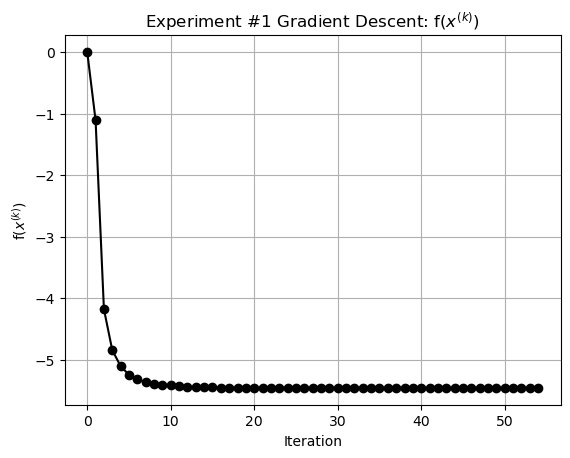

In [211]:
#Plot function values throughout gradient descent
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #1 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

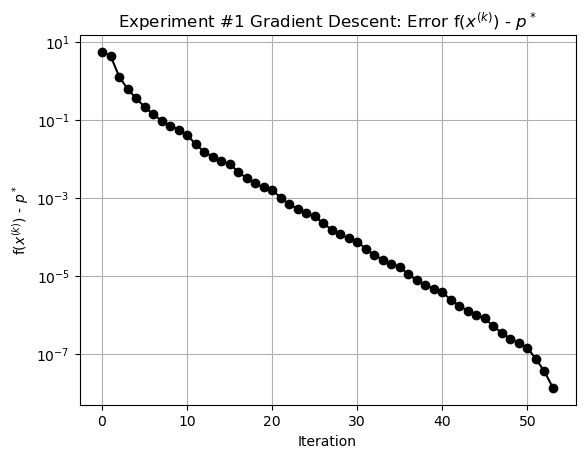

In [212]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed0
gradient_descent_gap_to_optimal = gradient_descent_gap_to_optimal[:-1]

plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #1 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

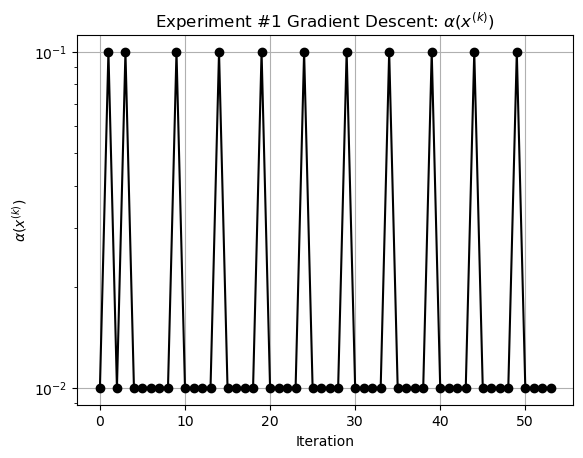

In [213]:
#Plot step sizes that were used during each iteration of gradient descent
plt.plot(list(range(len(gradient_descent_alpha_values))), gradient_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Experiment #1 Gradient Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #2: n = 10, m = 20, $\alpha = 0.01$, $\beta = 0.5$ 

In [214]:
#Global Variables
n = 10
m = 20
alpha = 0.01
beta = 0.5

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [215]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_alpha_values = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 11.30563226978405
Iteration: 2, Max of A @ x: 0.7199196548026612, Max of x^2: 0.14236592067558104, Current Function Value(Beginning of Iteration): -2.981509582199453, Norm of Gradient: 14.752586201056413
Iteration: 3, Max of A @ x: 0.35549495605881354, Max of x^2: 0.17847534033350645, Current Function Value(Beginning of Iteration): -4.227868603202955, Norm of Gradient: 4.478843748234512
Iteration: 4, Max of A @ x: 0.5146189214312682, Max of x^2: 0.28684569150251976, Current Function Value(Beginning of Iteration): -4.849363716549037, Norm of Gradient: 4.970035549935003
Iteration: 5, Max of A @ x: 0.2963482302839926, Max of x^2: 0.3174952125981366, Current Function Value(Beginning of Iteration): -5.107802330945442, Norm of Gradient: 2.7404514507429703
Iteration: 6, Max of A @ x: 0.40890194880932845, Max of x^2: 0.41738928474298037, Current Function Value(Beginning of 

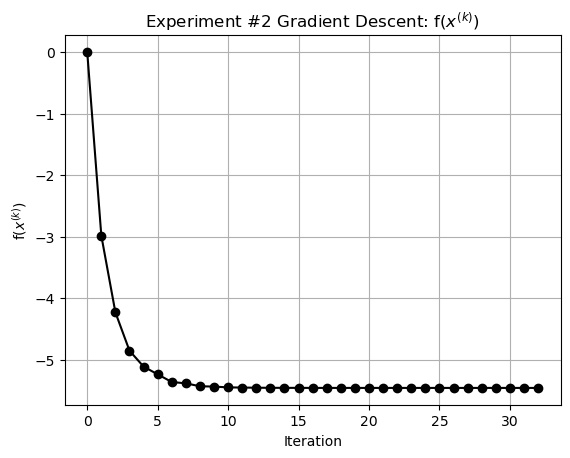

In [216]:
#Plot function values throughout gradient descent
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #2 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

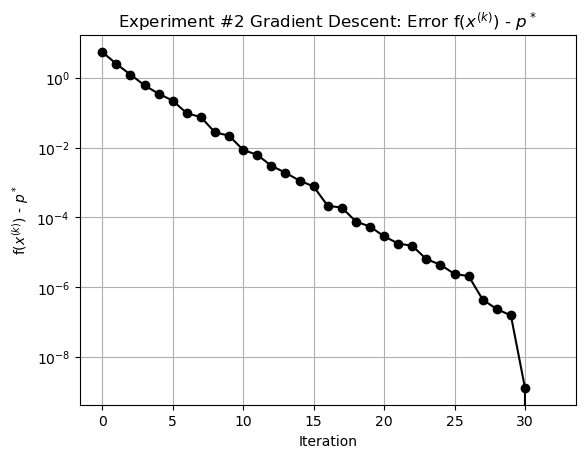

In [217]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed0
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #2 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

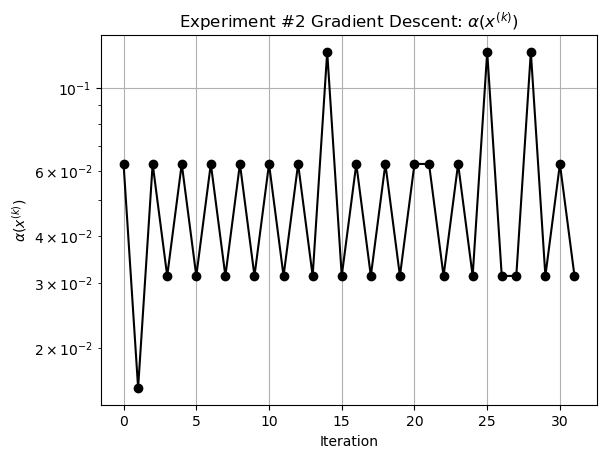

In [218]:
#Plot step sizes that were used during each iteration of gradient descent
plt.plot(list(range(len(gradient_descent_alpha_values))), gradient_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Experiment #2 Gradient Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #3: n = 10, m = 20, $\alpha = 0.15$, $\beta = 0.1$ 

In [219]:
#Global Variables
n = 10
m = 20
alpha = 0.15
beta = 0.1

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [220]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_alpha_values = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 11.30563226978405
Iteration: 2, Max of A @ x: 0.11518714476842583, Max of x^2: 0.003644567569294876, Current Function Value(Beginning of Iteration): -1.1088515187207195, Norm of Gradient: 8.658568803714667
Iteration: 3, Max of A @ x: 0.7163467394046283, Max of x^2: 0.30733437181374346, Current Function Value(Beginning of Iteration): -4.176387130915431, Norm of Gradient: 11.624647840396445
Iteration: 4, Max of A @ x: 0.37471907466531035, Max of x^2: 0.32115121600322555, Current Function Value(Beginning of Iteration): -4.841426473541867, Norm of Gradient: 3.602941411371429
Iteration: 5, Max of A @ x: 0.42789141569225, Max of x^2: 0.43809029925577103, Current Function Value(Beginning of Iteration): -5.100014776904235, Norm of Gradient: 4.05153317538587
Iteration: 6, Max of A @ x: 0.39411099374073166, Max of x^2: 0.42445090868624147, Current Function Value(Beginning of 

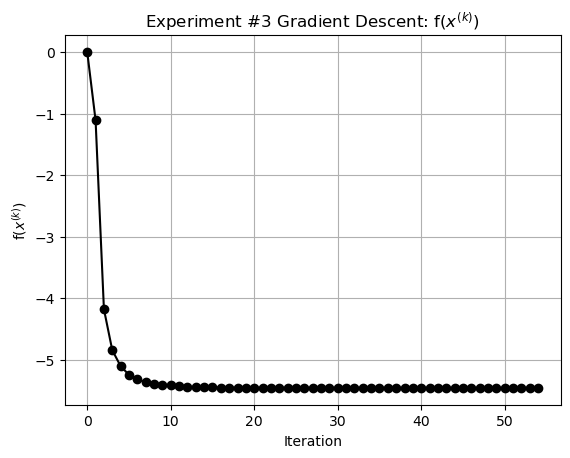

In [221]:
#Plot function values throughout gradient descent
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #3 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

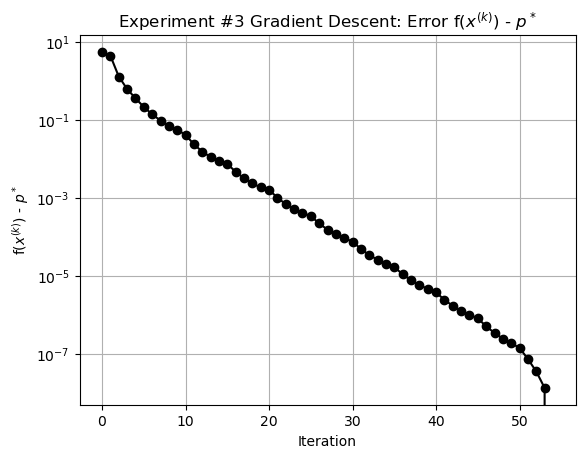

In [222]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed0
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #3 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

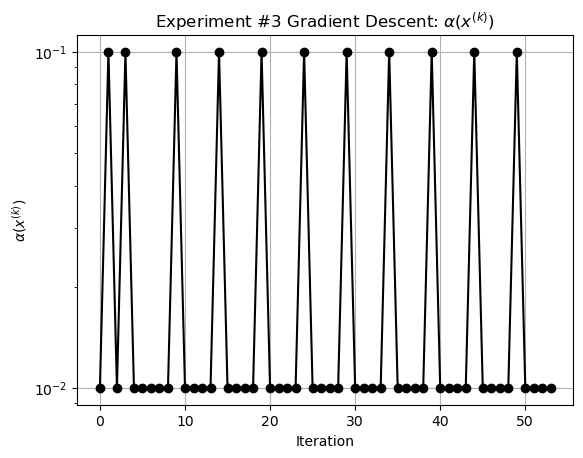

In [223]:
#Plot step sizes that were used during each iteration of gradient descent
plt.plot(list(range(len(gradient_descent_alpha_values))), gradient_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Experiment #3 Gradient Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #4: n = 20, m = 40, $\alpha = 0.01$, $\beta = 0.1$ 

In [224]:
#Global Variables
n = 20
m = 40
alpha = 0.01
beta = 0.1

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [225]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_alpha_values = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star_seed1 = gradient_descent_function_values[-1] #the optimal function value is approximated as the last function value that we observed during gradient descent

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 31.76534506891576
Iteration: 2, Max of A @ x: 0.505541184570806, Max of x^2: 0.026322490997474125, Current Function Value(Beginning of Iteration): -7.751193633138395, Norm of Gradient: 18.935536498025243
Iteration: 3, Max of A @ x: 0.6666598595313311, Max of x^2: 0.07227013089150053, Current Function Value(Beginning of Iteration): -10.887292214033991, Norm of Gradient: 14.737742759541781
Iteration: 4, Max of A @ x: 0.6765241030180773, Max of x^2: 0.125258147192517, Current Function Value(Beginning of Iteration): -12.889342963703303, Norm of Gradient: 12.563076590411104
Iteration: 5, Max of A @ x: 0.6909544577191962, Max of x^2: 0.17849405429537815, Current Function Value(Beginning of Iteration): -14.36864847069429, Norm of Gradient: 11.044320881595512
Iteration: 6, Max of A @ x: 0.6885764996225541, Max of x^2: 0.23294858992355136, Current Function Value(Beginning of

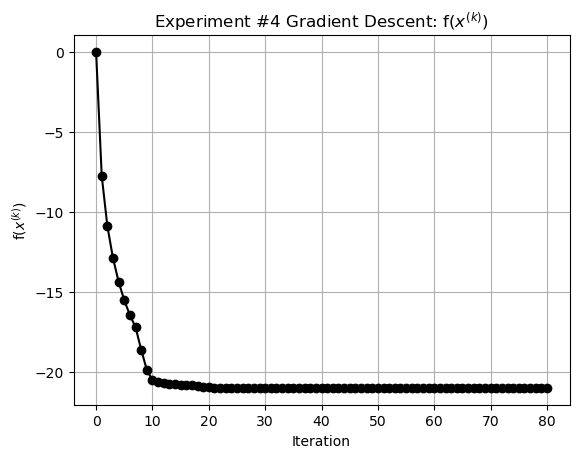

In [226]:
#Plot function values throughout gradient descent
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #4 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

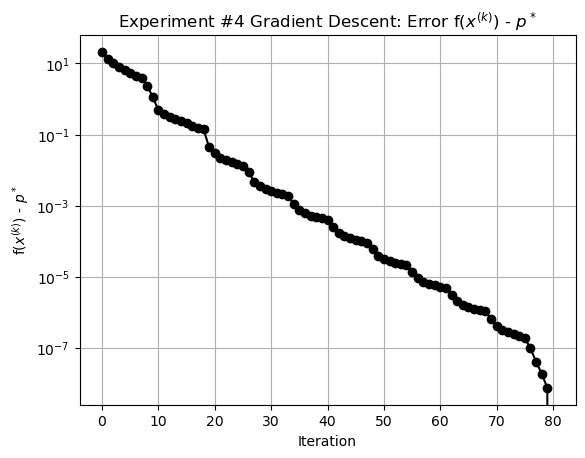

In [227]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed1
gradient_descent_gap_to_optimal = gradient_descent_gap_to_optimal[:-1]
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #4 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

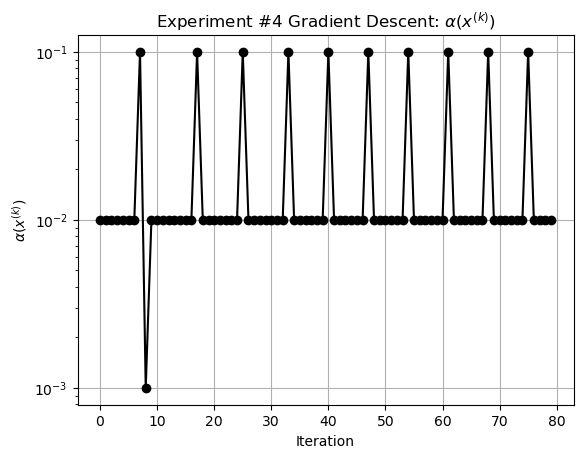

In [228]:
#Plot step sizes that were used during each iteration of gradient descent
plt.plot(list(range(len(gradient_descent_alpha_values))), gradient_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Experiment #4 Gradient Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #5: n = 20, m = 40, $\alpha = 0.01$, $\beta = 0.5$ 

In [229]:
#Global Variables
n = 20
m = 40
alpha = 0.01
beta = 0.5

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [230]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_alpha_values = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 31.76534506891576
Iteration: 2, Max of A @ x: 0.7899081008918841, Max of x^2: 0.06426389403680204, Current Function Value(Beginning of Iteration): -10.288240602802093, Norm of Gradient: 16.878010618518825
Iteration: 3, Max of A @ x: 0.8782424471252982, Max of x^2: 0.3025350404874245, Current Function Value(Beginning of Iteration): -12.562635577247853, Norm of Gradient: 58.37071805190583
Iteration: 4, Max of A @ x: 0.5717860982788951, Max of x^2: 0.26629422509862544, Current Function Value(Beginning of Iteration): -15.972921874025404, Norm of Gradient: 10.663547844628598
Iteration: 5, Max of A @ x: 0.8763167234282013, Max of x^2: 0.4458454753801965, Current Function Value(Beginning of Iteration): -17.980205526273547, Norm of Gradient: 20.340395302232405
Iteration: 6, Max of A @ x: 0.6128381917938688, Max of x^2: 0.477840797738969, Current Function Value(Beginning of 

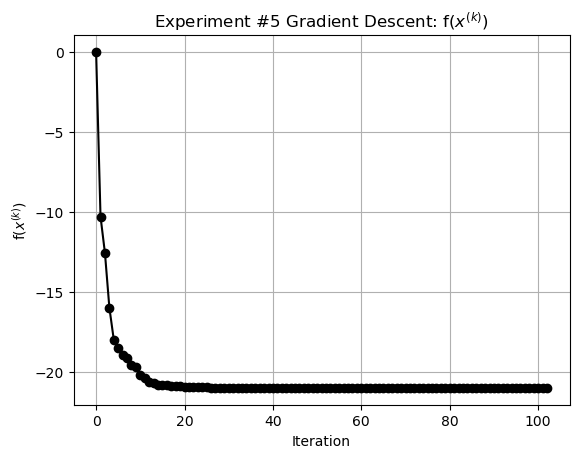

In [231]:
#Plot function values throughout gradient descent
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #5 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

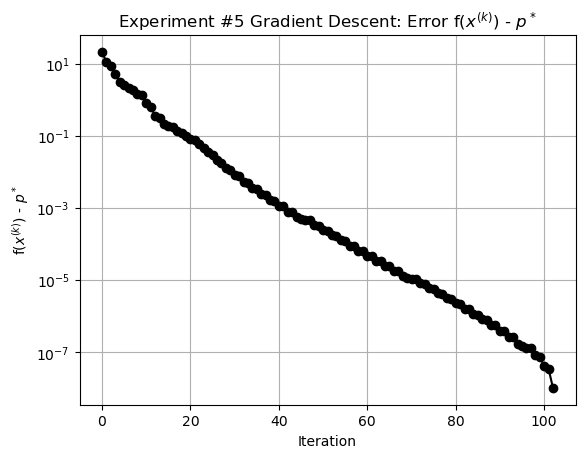

In [232]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed1
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #5 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

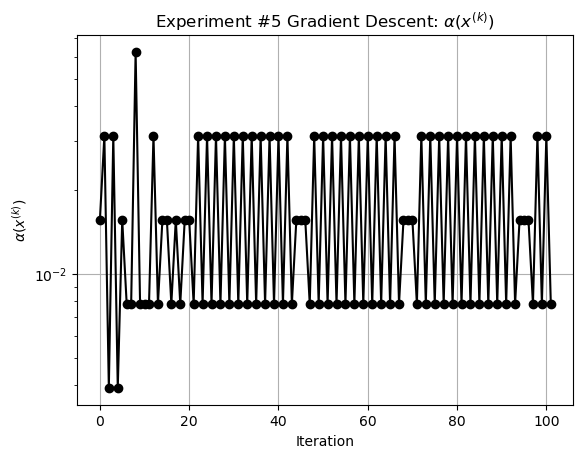

In [233]:
#Plot step sizes that were used during each iteration of gradient descent
plt.plot(list(range(len(gradient_descent_alpha_values))), gradient_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Experiment #5 Gradient Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #6: n = 20, m = 40, $\alpha = 0.15$, $\beta = 0.1$ 

In [234]:
#Global Variables
n = 20
m = 40
alpha = 0.15
beta = 0.1

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [235]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_alpha_values = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 31.76534506891576
Iteration: 2, Max of A @ x: 0.505541184570806, Max of x^2: 0.026322490997474125, Current Function Value(Beginning of Iteration): -7.751193633138395, Norm of Gradient: 18.935536498025243
Iteration: 3, Max of A @ x: 0.6666598595313311, Max of x^2: 0.07227013089150053, Current Function Value(Beginning of Iteration): -10.887292214033991, Norm of Gradient: 14.737742759541781
Iteration: 4, Max of A @ x: 0.6765241030180773, Max of x^2: 0.125258147192517, Current Function Value(Beginning of Iteration): -12.889342963703303, Norm of Gradient: 12.563076590411104
Iteration: 5, Max of A @ x: 0.6909544577191962, Max of x^2: 0.17849405429537815, Current Function Value(Beginning of Iteration): -14.36864847069429, Norm of Gradient: 11.044320881595512
Iteration: 6, Max of A @ x: 0.6885764996225541, Max of x^2: 0.23294858992355136, Current Function Value(Beginning of

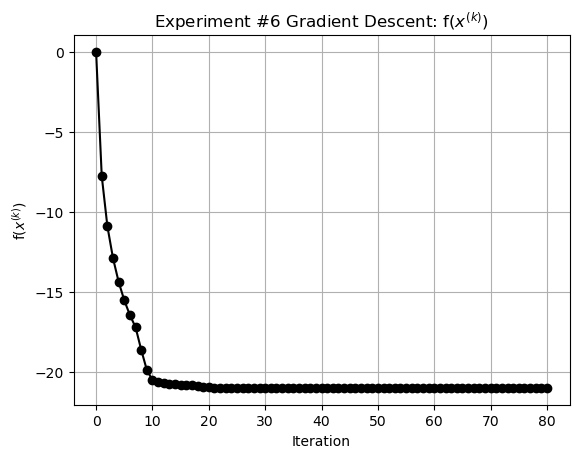

In [236]:
#Plot function values throughout gradient descent
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #6 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

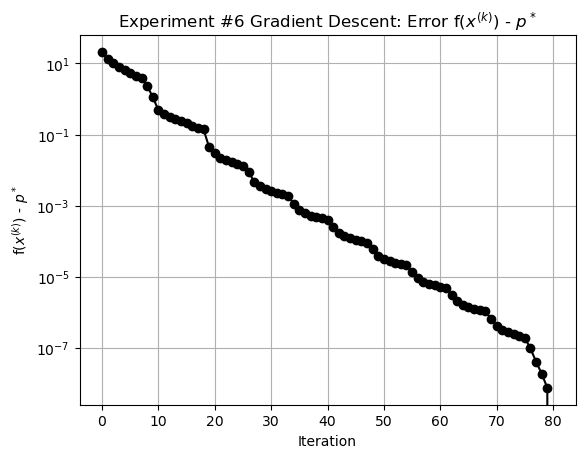

In [237]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed1
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #6 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

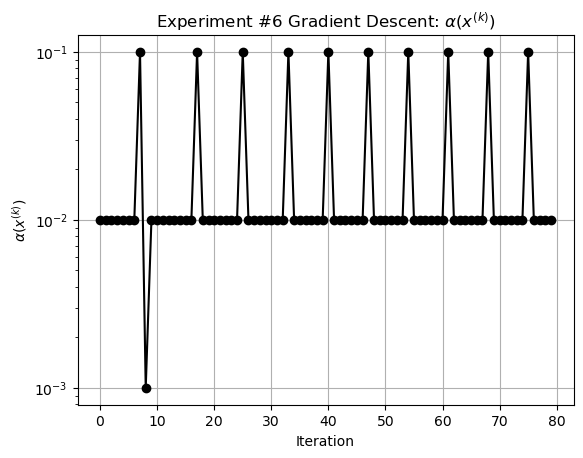

In [238]:
#Plot step sizes that were used during each iteration of gradient descent
plt.plot(list(range(len(gradient_descent_alpha_values))), gradient_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Experiment #6 Gradient Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #7: n = 5, m = 10, $\alpha = 0.01$, $\beta = 0.1$ 

In [ ]:
#Global Variables
n = 5
m = 10
alpha = 0.01
beta = 0.1

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [ ]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_alpha_values = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star_seed2 = gradient_descent_function_values[-1] #the optimal function value is approximated as the last function value that we observed during gradient descent

In [ ]:
#Plot function values throughout gradient descent
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #7 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

In [ ]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed2
gradient_descent_gap_to_optimal = gradient_descent_gap_to_optimal[:-1]
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #7 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [ ]:
#Plot step sizes that were used during each iteration of gradient descent
plt.plot(list(range(len(gradient_descent_alpha_values))), gradient_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Experiment #7 Gradient Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #8: n = 5, m = 10, $\alpha = 0.01$, $\beta = 0.5$ 

In [ ]:
#Global Variables
n = 5
m = 10
alpha = 0.01
beta = 0.5

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [ ]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_alpha_values = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

In [ ]:
#Plot function values throughout gradient descent
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #8 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

In [ ]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed2
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #8 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [ ]:
#Plot step sizes that were used during each iteration of gradient descent
plt.plot(list(range(len(gradient_descent_alpha_values))), gradient_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Experiment #8 Gradient Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #9: n = 5, m = 10, $\alpha = 0.15$, $\beta = 0.1$ 

In [ ]:
#Global Variables
n = 5
m = 10
alpha = 0.15
beta = 0.1

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [ ]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_alpha_values = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

In [ ]:
#Plot function values throughout gradient descent
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #9 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

In [ ]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed2
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #9 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [ ]:
#Plot step sizes that were used during each iteration of gradient descent
plt.plot(list(range(len(gradient_descent_alpha_values))), gradient_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Experiment #9 Gradient Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

Observations: 
- As we increase $\alpha$ and $\beta$, this slows down the convergence of the Gradient Descent Algorithm

## 9.30 (b)

### Experiment #1: n = 10, m = 20, $\alpha = 0.01$, $\beta = 0.1$ 

In [239]:
#Global Variables
n = 10
m = 20
alpha = 0.01
beta = 0.1
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [240]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_alpha_values = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 11.30563226978405, Newton Parameter: 7.498688286982669
Iteration: 2, Max of A @ x: 0.2756571066658716, Max of x^2: 0.29523816126718805, Current Function Value(Beginning of Iteration): -4.6479699445328, Norm of Gradient: 3.999629124943478, Newton Parameter: 1.4939235575207104
Iteration: 3, Max of A @ x: 0.2756571071740729, Max of x^2: 0.29523816331355857, Current Function Value(Beginning of Iteration): -4.647969959472036, Norm of Gradient: 3.999629084947185, Newton Parameter: 1.4939235319698114
Iteration: 4, Max of A @ x: 0.32647723738001055, Max of x^2: 0.5353349917050478, Current Function Value(Beginning of Iteration): -5.419923923574741, Norm of Gradient: 0.7709067474041433, Newton Parameter: 0.06656433553438997
Iteration: 5, Max of A @ x: 0.32647723739147394, Max of x^2: 0.5353349912701524, Current Function Value(Beginning of Iteration): -5.419923924240385, Norm 

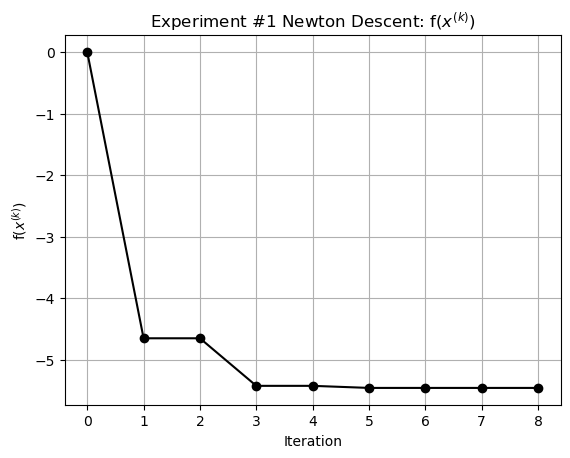

In [241]:
#Plot function values throughout Newton's Method
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #1 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

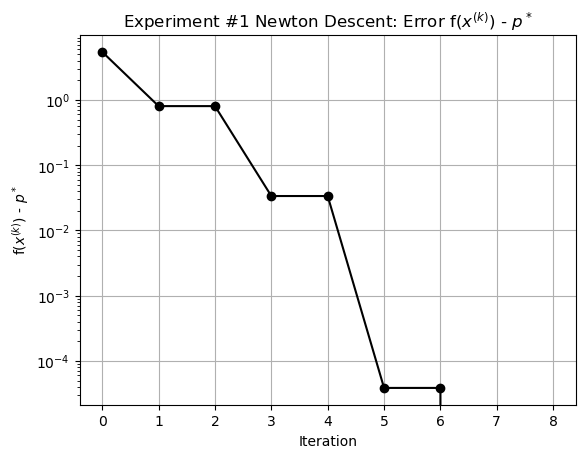

In [242]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed0
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #1 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [243]:
#Print step sizes during Newton's Method
newton_descent_alpha_values

array([1.e+00, 1.e-08, 1.e+00, 1.e-08, 1.e+00, 1.e-06, 1.e+00, 1.e-06])

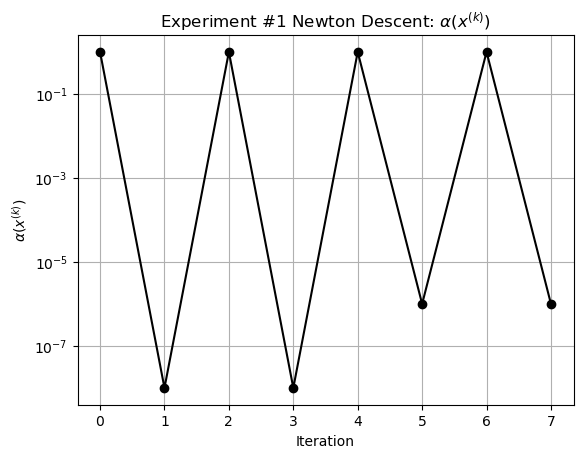

In [244]:
#Plot step sizes during Newton's Method
plt.plot(list(range(len(newton_descent_alpha_values))), newton_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Experiment #1 Newton Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #2: n = 10, m = 20, $\alpha = 0.01$, $\beta = 0.5$ 

In [245]:
#Global Variables
n = 10
m = 20
alpha = 0.01
beta = 0.5

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [246]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_alpha_values = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 11.30563226978405, Newton Parameter: 7.498688286982669
Iteration: 2, Max of A @ x: 0.2756571066658716, Max of x^2: 0.29523816126718805, Current Function Value(Beginning of Iteration): -4.6479699445328, Norm of Gradient: 3.999629124943478, Newton Parameter: 1.4939235575207104
Iteration: 3, Max of A @ x: 0.2756571081804295, Max of x^2: 0.2952381673658474, Current Function Value(Beginning of Iteration): -4.647969989055191, Norm of Gradient: 3.999629005745241, Newton Parameter: 1.493923481373103
Iteration: 4, Max of A @ x: 0.32647723760105496, Max of x^2: 0.535334990160842, Current Function Value(Beginning of Iteration): -5.419923926276641, Norm of Gradient: 0.7709067183513227, Newton Parameter: 0.06656433024709289
Iteration: 5, Max of A @ x: 0.32647723773771076, Max of x^2: 0.535334984976485, Current Function Value(Beginning of Iteration): -5.419923934211727, Norm of G

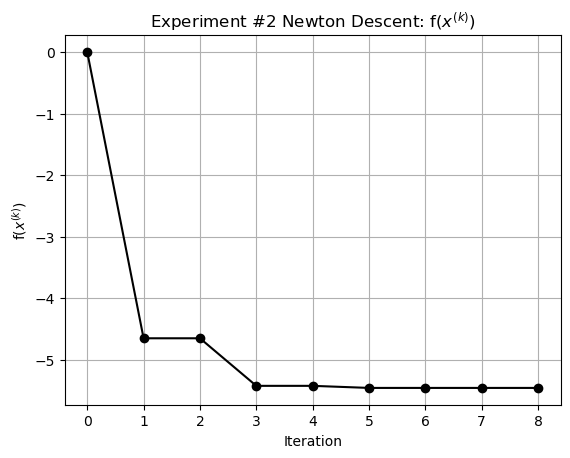

In [247]:
#Plot function values throughout Newton's Method
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #2 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

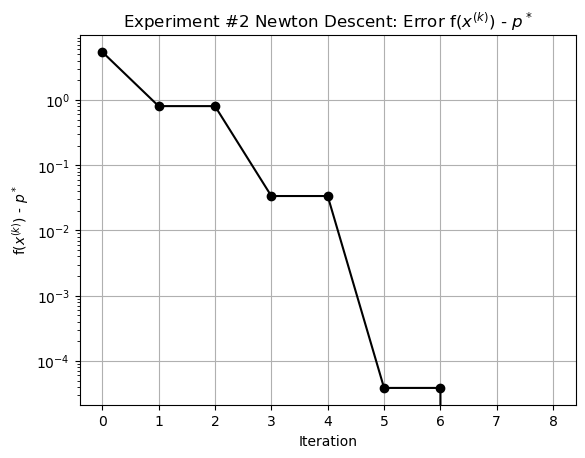

In [248]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed0
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #2 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [249]:
#Print step sizes during Newton's Method
newton_descent_alpha_values

array([1.00000000e+00, 2.98023224e-08, 1.00000000e+00, 1.19209290e-07,
       1.00000000e+00, 1.90734863e-06, 1.00000000e+00, 1.22070312e-04])

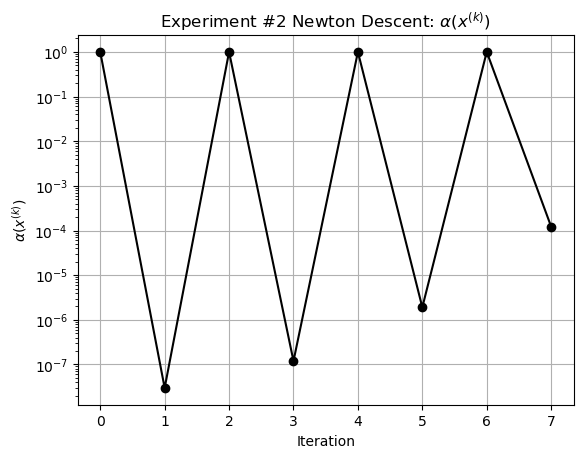

In [250]:
#Plot step sizes during Newton's Method
plt.plot(list(range(len(newton_descent_alpha_values))), newton_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Experiment #2 Newton Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #3: n = 10, m = 20, $\alpha = 0.15$, $\beta = 0.1$ 

In [251]:
#Global Variables
n = 10
m = 20
alpha = 0.15
beta = 0.1

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [252]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_alpha_values = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 11.30563226978405, Newton Parameter: 7.498688286982669
Iteration: 2, Max of A @ x: 0.2756571066658716, Max of x^2: 0.29523816126718805, Current Function Value(Beginning of Iteration): -4.6479699445328, Norm of Gradient: 3.999629124943478, Newton Parameter: 1.4939235575207104
Iteration: 3, Max of A @ x: 0.2756571071740729, Max of x^2: 0.29523816331355857, Current Function Value(Beginning of Iteration): -4.647969959472036, Norm of Gradient: 3.999629084947185, Newton Parameter: 1.4939235319698114
Iteration: 4, Max of A @ x: 0.32647723738001055, Max of x^2: 0.5353349917050478, Current Function Value(Beginning of Iteration): -5.419923923574741, Norm of Gradient: 0.7709067474041433, Newton Parameter: 0.06656433553438997
Iteration: 5, Max of A @ x: 0.32647723739147394, Max of x^2: 0.5353349912701524, Current Function Value(Beginning of Iteration): -5.419923924240385, Norm 

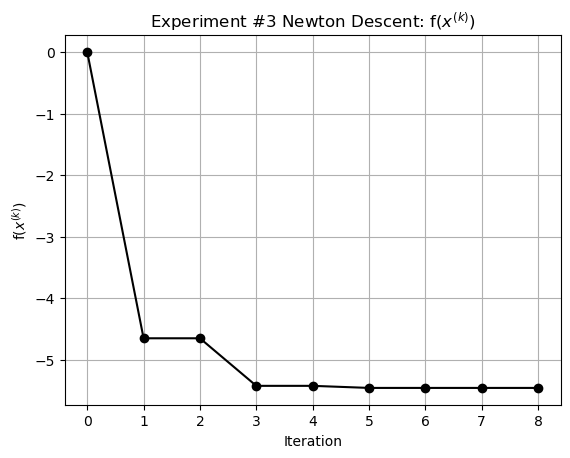

In [253]:
#Plot function values throughout Newton's Method
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #3 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

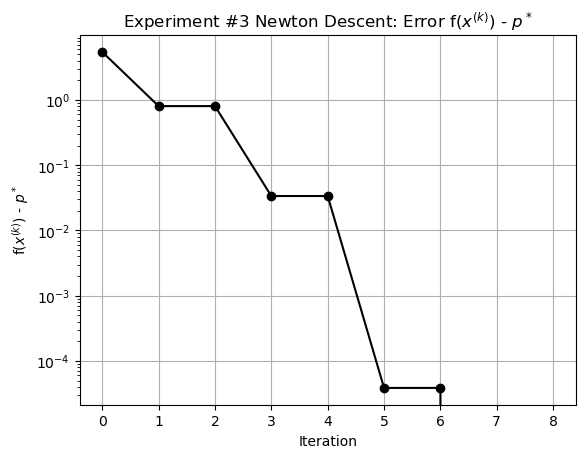

In [254]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed0
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #3 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [255]:
#Print step sizes during Newton's Method
newton_descent_alpha_values

array([1.e+00, 1.e-08, 1.e+00, 1.e-08, 1.e+00, 1.e-06, 1.e+00, 1.e-06])

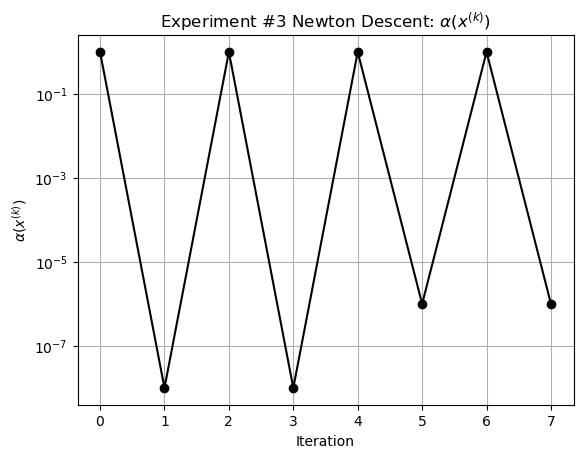

In [256]:
#Plot step sizes during Newton's Method
plt.plot(list(range(len(newton_descent_alpha_values))), newton_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Experiment #3 Newton Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #4: n = 20, m = 40, $\alpha = 0.01$, $\beta = 0.1$ 

In [257]:
#Global Variables
n = 20
m = 40
alpha = 0.01
beta = 0.1

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [258]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_alpha_values = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 31.76534506891576, Newton Parameter: 21.921908022329713
Iteration: 2, Max of A @ x: 0.48715288373329496, Max of x^2: 0.15999930123964082, Current Function Value(Beginning of Iteration): -14.601193983540844, Norm of Gradient: 13.701721740610433, Newton Parameter: 11.868028493564575
Iteration: 3, Max of A @ x: 0.4871528850537917, Max of x^2: 0.15999930463922632, Current Function Value(Beginning of Iteration): -14.601194102221129, Norm of Gradient: 13.701721603593219, Newton Parameter: 11.868028339636792
Iteration: 4, Max of A @ x: 0.6192025474118585, Max of x^2: 0.863857736927247, Current Function Value(Beginning of Iteration): -20.433657126476202, Norm of Gradient: 9.285237910926154, Newton Parameter: 0.8771063741587057
Iteration: 5, Max of A @ x: 0.6192025477459002, Max of x^2: 0.8638577361469887, Current Function Value(Beginning of Iteration): -20.433657135247266, 

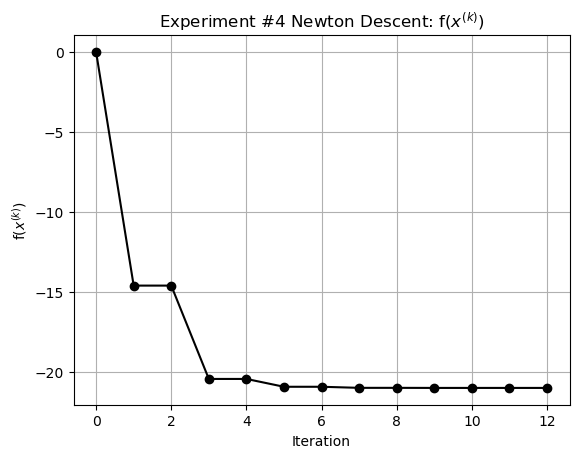

In [259]:
#Plot function values throughout Newton's Method
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #4 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

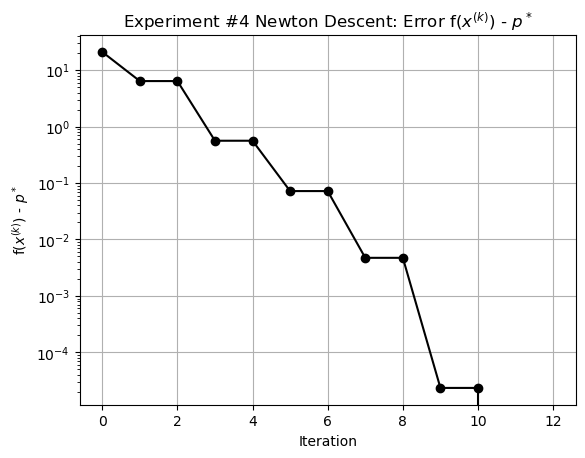

In [260]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed1
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #4 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [261]:
#Print step sizes during Newton's Method
newton_descent_alpha_values

array([1.e+00, 1.e-08, 1.e+00, 1.e-08, 1.e+00, 1.e-08, 1.e+00, 1.e-08,
       1.e+00, 1.e-05, 1.e+00, 1.e-03])

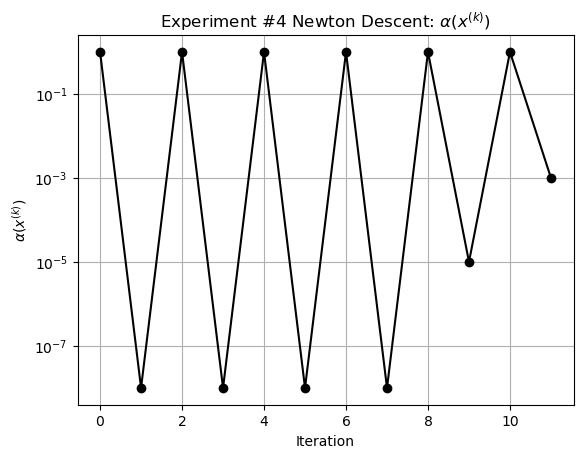

In [262]:
#Plot step sizes during Newton's Method
plt.plot(list(range(len(newton_descent_alpha_values))), newton_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Experiment #4 Newton Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #5: n = 20, m = 40, $\alpha = 0.01$, $\beta = 0.5$ 

In [263]:
#Global Variables
n = 20
m = 40
alpha = 0.01
beta = 0.5

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [264]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_alpha_values = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 31.76534506891576, Newton Parameter: 21.921908022329713
Iteration: 2, Max of A @ x: 0.48715288373329496, Max of x^2: 0.15999930123964082, Current Function Value(Beginning of Iteration): -14.601193983540844, Norm of Gradient: 13.701721740610433, Newton Parameter: 11.868028493564575
Iteration: 3, Max of A @ x: 0.4871528839792566, Max of x^2: 0.15999930187286296, Current Function Value(Beginning of Iteration): -14.60119400564677, Norm of Gradient: 13.70172171508899, Newton Parameter: 11.86802846489329
Iteration: 4, Max of A @ x: 0.6192025467539374, Max of x^2: 0.8638577319246692, Current Function Value(Beginning of Iteration): -20.4336571438652, Norm of Gradient: 9.285237383050971, Newton Parameter: 0.8771063674072935
Iteration: 5, Max of A @ x: 0.6192025477494592, Max of x^2: 0.8638577295993182, Current Function Value(Beginning of Iteration): -20.433657170005006, Norm

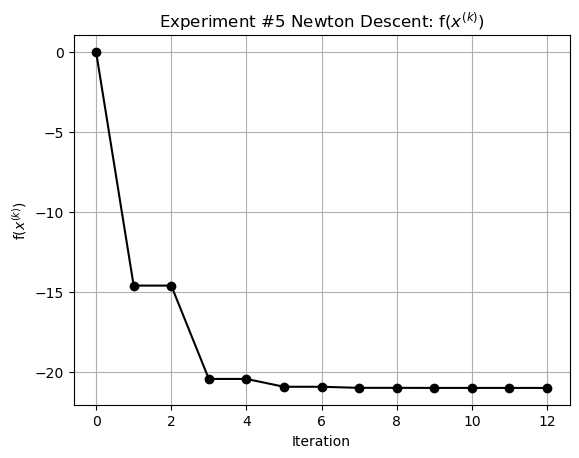

In [265]:
#Plot function values throughout Newton's Method
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #5 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

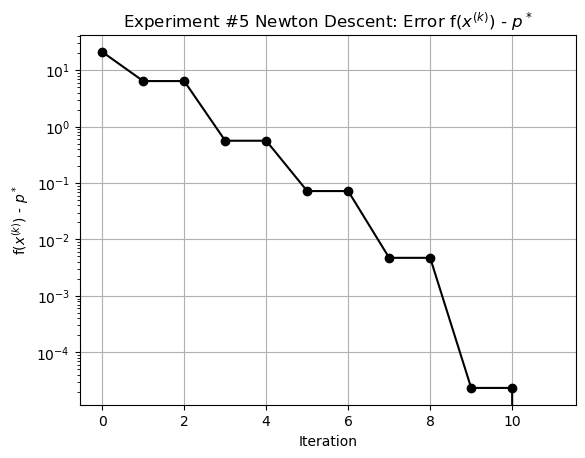

In [266]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed1
newton_descent_gap_to_optimal = newton_descent_gap_to_optimal[:-1]

plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #5 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [267]:
#Print step sizes during Newton's Method
newton_descent_alpha_values

array([1.00000000e+00, 1.86264515e-09, 1.00000000e+00, 2.98023224e-08,
       1.00000000e+00, 1.86264515e-09, 1.00000000e+00, 5.96046448e-08,
       1.00000000e+00, 7.62939453e-06, 1.00000000e+00, 1.95312500e-03])

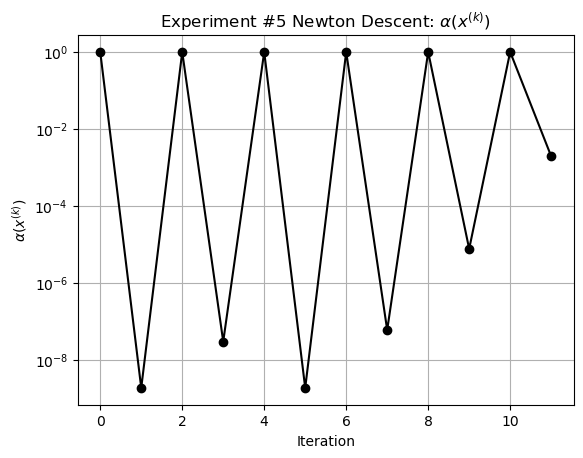

In [268]:
#Plot step sizes during Newton's Method
plt.plot(list(range(len(newton_descent_alpha_values))), newton_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Experiment #5 Newton Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

### Experiment #6: n = 20, m = 40, $\alpha = 0.15$, $\beta = 0.1$ 

In [269]:
#Global Variables
n = 20
m = 40
alpha = 0.15
beta = 0.1

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [270]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_alpha_values = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 31.76534506891576, Newton Parameter: 21.921908022329713
Iteration: 2, Max of A @ x: 0.48715288373329496, Max of x^2: 0.15999930123964082, Current Function Value(Beginning of Iteration): -14.601193983540844, Norm of Gradient: 13.701721740610433, Newton Parameter: 11.868028493564575
Iteration: 3, Max of A @ x: 0.4871528850537917, Max of x^2: 0.15999930463922632, Current Function Value(Beginning of Iteration): -14.601194102221129, Norm of Gradient: 13.701721603593219, Newton Parameter: 11.868028339636792
Iteration: 4, Max of A @ x: 0.6192025474118585, Max of x^2: 0.863857736927247, Current Function Value(Beginning of Iteration): -20.433657126476202, Norm of Gradient: 9.285237910926154, Newton Parameter: 0.8771063741587057
Iteration: 5, Max of A @ x: 0.6192025477459002, Max of x^2: 0.8638577361469887, Current Function Value(Beginning of Iteration): -20.433657135247266, 

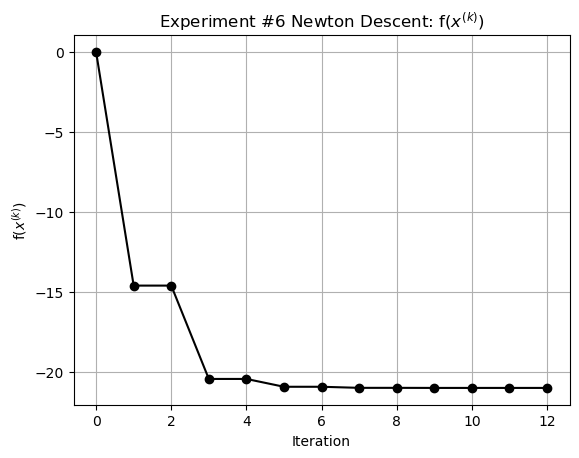

In [271]:
#Plot function values throughout Newton's Method
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #6 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

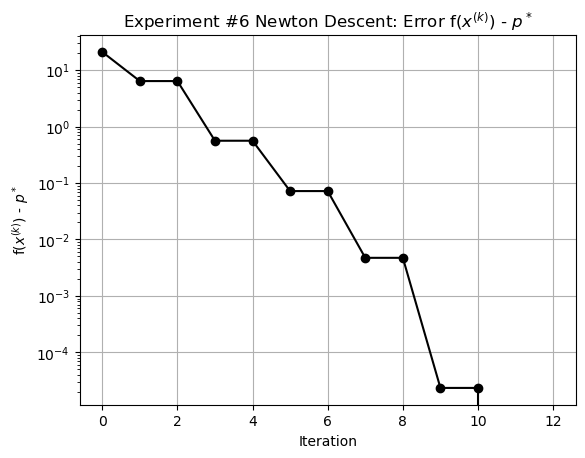

In [272]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed1
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #6 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [273]:
#Print step sizes during Newton's Method
newton_descent_alpha_values

array([1.e+00, 1.e-08, 1.e+00, 1.e-08, 1.e+00, 1.e-08, 1.e+00, 1.e-08,
       1.e+00, 1.e-05, 1.e+00, 1.e-03])

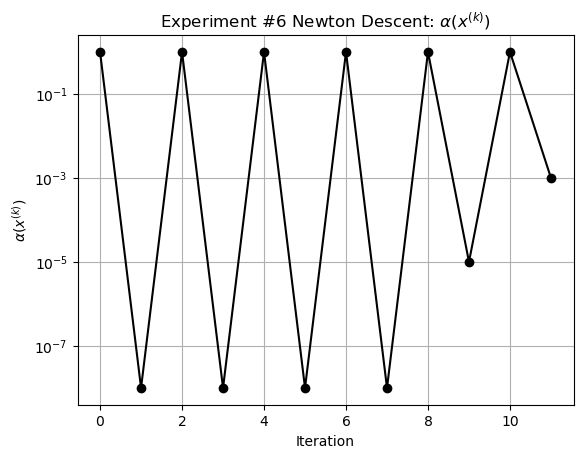

In [274]:
#Plot step sizes during Newton's Method
plt.plot(list(range(len(newton_descent_alpha_values))), newton_descent_alpha_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha(x^{(k)})$')
plt.yscale('log')
plt.title(r'Experiment #6 Newton Descent: $\alpha(x^{(k)})$')
plt.grid(True)
plt.show()

Observations: 
- Backtracking Parameters $\alpha$ and $\beta$ do not affect the performance of Newton's Method that much
- Performance is scaling well with problem size

## 9.31 (a)

### Experiment #1

In [275]:
#Global Variables
n = 10
m = 20
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [276]:
#Run Newton's Method where Hessian is reused every 1 iteration
reused_newton_descent_iterates_N1, reused_newton_descent_function_values_N1, reused_newton_descent_alpha_values_N1 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 1)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 11.30563226978405, Newton Parameter: 7.498688286982669
Iteration: 2, Max of A @ x: 0.2756571066658716, Max of x^2: 0.29523816126718805, Current Function Value(Beginning of Iteration): -4.6479699445328, Norm of Gradient: 3.999629124943478, Newton Parameter: 1.4939235575207104
Iteration: 3, Max of A @ x: 0.2756571081804295, Max of x^2: 0.2952381673658474, Current Function Value(Beginning of Iteration): -4.647969989055191, Norm of Gradient: 3.999629005745241, Newton Parameter: 1.493923481373103
Iteration: 4, Max of A @ x: 0.32647723760105496, Max of x^2: 0.535334990160842, Current Function Value(Beginning of Iteration): -5.419923926276641, Norm of Gradient: 0.7709067183513227, Newton Parameter: 0.06656433024709289
Iteration: 5, Max of A @ x: 0.32647723773771076, Max of x^2: 0.535334984976485, Current Function Value(Beginning of Iteration): -5.419923934211727, Norm of G

In [277]:
#Run Newton's Method where Hessian is reused every 2 iteration
reused_newton_descent_iterates_N2, reused_newton_descent_function_values_N2, reused_newton_descent_alpha_values_N2 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 2)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 11.30563226978405, Newton Parameter: 7.498688286982669
Iteration: 2, Max of A @ x: 0.2756571066658716, Max of x^2: 0.29523816126718805, Current Function Value(Beginning of Iteration): -4.6479699445328, Norm of Gradient: 3.999629124943478, Newton Parameter: 0.7252157792927123
Iteration: 3, Max of A @ x: 0.2756571085784057, Max of x^2: 0.2952381699875512, Current Function Value(Beginning of Iteration): -4.647969987759029, Norm of Gradient: 3.9996290140038653, Newton Parameter: 1.4939234784601583
Iteration: 4, Max of A @ x: 0.32647723723246613, Max of x^2: 0.5353349887609553, Current Function Value(Beginning of Iteration): -5.419923926184152, Norm of Gradient: 0.7709067155014471, Newton Parameter: 0.07191619742134467
Iteration: 5, Max of A @ x: 0.3264772370521839, Max of x^2: 0.5353349861482033, Current Function Value(Beginning of Iteration): -5.419923928327423, Norm o

In [278]:
#Run Newton's Method where Hessian is reused every 5 iteration
reused_newton_descent_iterates_N5, reused_newton_descent_function_values_N5, reused_newton_descent_alpha_values_N5 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 5)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 11.30563226978405, Newton Parameter: 7.498688286982669
Iteration: 2, Max of A @ x: 0.2756571066658716, Max of x^2: 0.29523816126718805, Current Function Value(Beginning of Iteration): -4.6479699445328, Norm of Gradient: 3.999629124943478, Newton Parameter: 0.7252157792927123
Iteration: 3, Max of A @ x: 0.2756571085784057, Max of x^2: 0.2952381699875512, Current Function Value(Beginning of Iteration): -4.647969987759029, Norm of Gradient: 3.9996290140038653, Newton Parameter: 0.725215733195013
Iteration: 4, Max of A @ x: 0.30774410550821774, Max of x^2: 0.4596665127391829, Current Function Value(Beginning of Iteration): -5.173138685546649, Norm of Gradient: 2.2295752679977165, Newton Parameter: 0.1837186003707839
Iteration: 5, Max of A @ x: 0.3077441053534129, Max of x^2: 0.45966651475572634, Current Function Value(Beginning of Iteration): -5.173138707447612, Norm of

In [279]:
#Run Newton's Method where Hessian is reused every 10 iteration
reused_newton_descent_iterates_N10, reused_newton_descent_function_values_N10, reused_newton_descent_alpha_values_N10 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 10)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 11.30563226978405, Newton Parameter: 7.498688286982669
Iteration: 2, Max of A @ x: 0.2756571066658716, Max of x^2: 0.29523816126718805, Current Function Value(Beginning of Iteration): -4.6479699445328, Norm of Gradient: 3.999629124943478, Newton Parameter: 0.7252157792927123
Iteration: 3, Max of A @ x: 0.2756571085784057, Max of x^2: 0.2952381699875512, Current Function Value(Beginning of Iteration): -4.647969987759029, Norm of Gradient: 3.9996290140038653, Newton Parameter: 0.725215733195013
Iteration: 4, Max of A @ x: 0.30774410550821774, Max of x^2: 0.4596665127391829, Current Function Value(Beginning of Iteration): -5.173138685546649, Norm of Gradient: 2.2295752679977165, Newton Parameter: 0.1837186003707839
Iteration: 5, Max of A @ x: 0.3077441053534129, Max of x^2: 0.45966651475572634, Current Function Value(Beginning of Iteration): -5.173138707447612, Norm of

Gap to Optimal for N = 1: [ 5.45365585e+00  8.05685901e-01  8.05685856e-01  3.37319192e-02
  3.37319112e-02  3.86264696e-05  3.86263225e-05 -5.45094920e-08
 -5.45096963e-08]
Gap to Optimal for N = 2: [ 5.45365585e+00  8.05685901e-01  8.05685858e-01  3.37319193e-02
  3.37319171e-02  3.86264735e-05  3.86264735e-05 -5.45094867e-08
 -5.45094867e-08]
Gap to Optimal for N = 5: [ 5.45365585e+00  8.05685901e-01  8.05685858e-01  2.80517160e-01
  2.80517138e-01  1.30580563e-01  1.30580548e-01  5.11133597e-04
  5.11133378e-04  5.64673491e-06  5.64665670e-06 -5.53475754e-08
 -5.53475967e-08]
Gap to Optimal for N = 10: [ 5.45365585e+00  8.05685901e-01  8.05685858e-01  2.80517160e-01
  2.80517138e-01  1.30580563e-01  1.30580545e-01  6.56939625e-02
  6.56939450e-02  3.42224070e-02  3.42223981e-02  1.81453526e-05
  1.81450843e-05 -2.27440209e-08 -2.27517996e-08 -5.52745743e-08
 -5.52748620e-08]


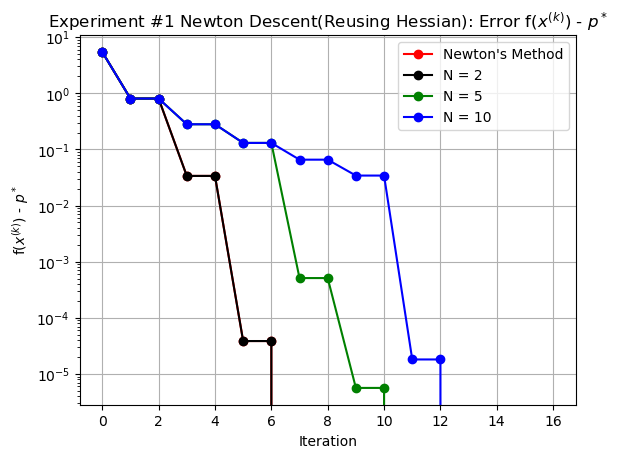

In [280]:
#Plot distance to optimal function value throughout Newton's Method for N = 1, 2, 5, 10
reused_newton_descent_gap_to_optimal_N1 = reused_newton_descent_function_values_N1 - p_star_seed0
reused_newton_descent_gap_to_optimal_N2 = reused_newton_descent_function_values_N2 - p_star_seed0
reused_newton_descent_gap_to_optimal_N5 = reused_newton_descent_function_values_N5 - p_star_seed0
reused_newton_descent_gap_to_optimal_N10 = reused_newton_descent_function_values_N10 - p_star_seed0

print(f"Gap to Optimal for N = 1: {reused_newton_descent_gap_to_optimal_N1}")
print(f"Gap to Optimal for N = 2: {reused_newton_descent_gap_to_optimal_N2}")
print(f"Gap to Optimal for N = 5: {reused_newton_descent_gap_to_optimal_N5}")
print(f"Gap to Optimal for N = 10: {reused_newton_descent_gap_to_optimal_N10}")

line1, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N1))), reused_newton_descent_gap_to_optimal_N1, marker='o', color='red', linestyle='-')
line2, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N2))), reused_newton_descent_gap_to_optimal_N2, marker='o', color='black', linestyle='-')
line3, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N5))), reused_newton_descent_gap_to_optimal_N5, marker='o', color='green', linestyle='-')
line4, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N10))), reused_newton_descent_gap_to_optimal_N10, marker='o', color='blue', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #1 Newton Descent(Reusing Hessian): Error f($x^{(k)}$) - $p^*$')
plt.legend(handles=[line1, line2, line3, line4], labels=['Newton\'s Method', 'N = 2', 'N = 5', 'N = 10'])
plt.grid(True)
plt.show()

### Experiment #2

In [281]:
#Global Variables
n = 10
m = 20
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [282]:
#Run Newton's Method where Hessian is reused every 1 iteration
reused_newton_descent_iterates_N1, reused_newton_descent_function_values_N1, reused_newton_descent_alpha_values_N1 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 1)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 19.153454079329176, Newton Parameter: 13.660824062378975
Iteration: 2, Max of A @ x: 0.4018379901403833, Max of x^2: 0.2505989890331257, Current Function Value(Beginning of Iteration): -8.879398063887285, Norm of Gradient: 7.912215094020721, Newton Parameter: 5.764588768040119
Iteration: 3, Max of A @ x: 0.40183799137301346, Max of x^2: 0.2505989911995027, Current Function Value(Beginning of Iteration): -8.87939810683682, Norm of Gradient: 7.9122150350701235, Newton Parameter: 5.764588714265375
Iteration: 4, Max of A @ x: 0.5672788074921759, Max of x^2: 0.6257080974748239, Current Function Value(Beginning of Iteration): -12.049441933674563, Norm of Gradient: 1.9079843478177514, Newton Parameter: 0.33623457280352986
Iteration: 5, Max of A @ x: 0.5672788069130323, Max of x^2: 0.6257080898180585, Current Function Value(Beginning of Iteration): -12.049441973756847, Norm

In [283]:
#Run Newton's Method where Hessian is reused every 2 iteration
reused_newton_descent_iterates_N2, reused_newton_descent_function_values_N2, reused_newton_descent_alpha_values_N2 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 2)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 19.153454079329176, Newton Parameter: 13.660824062378975
Iteration: 2, Max of A @ x: 0.4018379901403833, Max of x^2: 0.2505989890331257, Current Function Value(Beginning of Iteration): -8.879398063887285, Norm of Gradient: 7.912215094020721, Newton Parameter: 2.082353360013288
Iteration: 3, Max of A @ x: 0.4018379917418015, Max of x^2: 0.2505989913174405, Current Function Value(Beginning of Iteration): -8.87939809491677, Norm of Gradient: 7.912215049898169, Newton Parameter: 5.764588724924696
Iteration: 4, Max of A @ x: 0.5672788075128588, Max of x^2: 0.6257080967235531, Current Function Value(Beginning of Iteration): -12.049441932022898, Norm of Gradient: 1.9079843491628063, Newton Parameter: 0.4529444409961423
Iteration: 5, Max of A @ x: 0.5672788081594115, Max of x^2: 0.6257080829531466, Current Function Value(Beginning of Iteration): -12.04944195902049, Norm of 

In [284]:
#Run Newton's Method where Hessian is reused every 5 iteration
reused_newton_descent_iterates_N5, reused_newton_descent_function_values_N5, reused_newton_descent_alpha_values_N5 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 5)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 19.153454079329176, Newton Parameter: 13.660824062378975
Iteration: 2, Max of A @ x: 0.4018379901403833, Max of x^2: 0.2505989890331257, Current Function Value(Beginning of Iteration): -8.879398063887285, Norm of Gradient: 7.912215094020721, Newton Parameter: 2.082353360013288
Iteration: 3, Max of A @ x: 0.4018379917418015, Max of x^2: 0.2505989913174405, Current Function Value(Beginning of Iteration): -8.87939809491677, Norm of Gradient: 7.912215049898169, Newton Parameter: 2.0823533351287415
Iteration: 4, Max of A @ x: 0.5093073516071045, Max of x^2: 0.4273407925024527, Current Function Value(Beginning of Iteration): -10.54659906212708, Norm of Gradient: 5.1647411328181025, Newton Parameter: 0.8446315654035
Iteration: 5, Max of A @ x: 0.5093073561388579, Max of x^2: 0.427340798342473, Current Function Value(Beginning of Iteration): -10.54659916281501, Norm of Grad

In [285]:
#Run Newton's Method where Hessian is reused every 10 iteration
reused_newton_descent_iterates_N10, reused_newton_descent_function_values_N10, reused_newton_descent_alpha_values_N10 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 10)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 19.153454079329176, Newton Parameter: 13.660824062378975
Iteration: 2, Max of A @ x: 0.4018379901403833, Max of x^2: 0.2505989890331257, Current Function Value(Beginning of Iteration): -8.879398063887285, Norm of Gradient: 7.912215094020721, Newton Parameter: 2.082353360013288
Iteration: 3, Max of A @ x: 0.4018379917418015, Max of x^2: 0.2505989913174405, Current Function Value(Beginning of Iteration): -8.87939809491677, Norm of Gradient: 7.912215049898169, Newton Parameter: 2.0823533351287415
Iteration: 4, Max of A @ x: 0.5093073516071045, Max of x^2: 0.4273407925024527, Current Function Value(Beginning of Iteration): -10.54659906212708, Norm of Gradient: 5.1647411328181025, Newton Parameter: 0.8446315654035
Iteration: 5, Max of A @ x: 0.5093073561388579, Max of x^2: 0.427340798342473, Current Function Value(Beginning of Iteration): -10.54659916281501, Norm of Grad

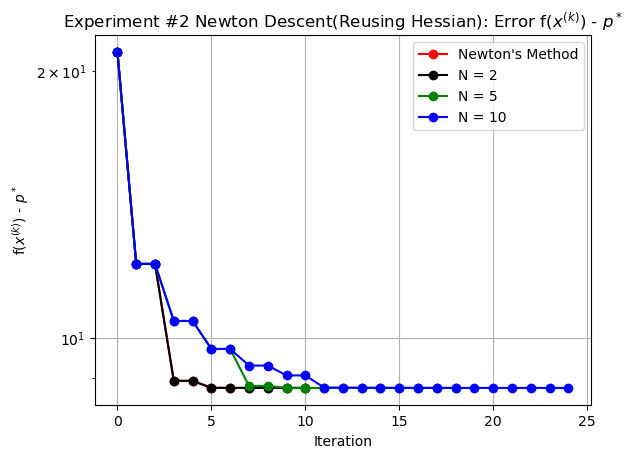

In [286]:
#Plot distance to optimal function value throughout Newton's Method for N = 1, 2, 5, 10
reused_newton_descent_gap_to_optimal_N1 = reused_newton_descent_function_values_N1 - p_star_seed1
reused_newton_descent_gap_to_optimal_N2 = reused_newton_descent_function_values_N2 - p_star_seed1
reused_newton_descent_gap_to_optimal_N5 = reused_newton_descent_function_values_N5 - p_star_seed1
reused_newton_descent_gap_to_optimal_N10 = reused_newton_descent_function_values_N10 - p_star_seed1

line1, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N1))), reused_newton_descent_gap_to_optimal_N1, marker='o', color='red', linestyle='-')
line2, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N2))), reused_newton_descent_gap_to_optimal_N2, marker='o', color='black', linestyle='-')
line3, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N5))), reused_newton_descent_gap_to_optimal_N5, marker='o', color='green', linestyle='-')
line4, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N10))), reused_newton_descent_gap_to_optimal_N10, marker='o', color='blue', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #2 Newton Descent(Reusing Hessian): Error f($x^{(k)}$) - $p^*$')
plt.legend(handles=[line1, line2, line3, line4], labels=['Newton\'s Method', 'N = 2', 'N = 5', 'N = 10'])
plt.grid(True)
plt.show()

### Experiment #3

In [287]:
#Global Variables
n = 10
m = 20
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [288]:
#Run Newton's Method where Hessian is reused every 1 iteration
reused_newton_descent_iterates_N1, reused_newton_descent_function_values_N1, reused_newton_descent_alpha_values_N1 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 1)
p_star_seed2 = reused_newton_descent_function_values_N1[-1] #the optimal function value is approximated as the last function value that we observed during Newton's Method

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 20.738329804807222, Newton Parameter: 9.080400878169842
Iteration: 2, Max of A @ x: 0.5593503078787587, Max of x^2: 0.1888337052414108, Current Function Value(Beginning of Iteration): -5.750218143635475, Norm of Gradient: 6.8418602503177475, Newton Parameter: 2.997418072430046
Iteration: 3, Max of A @ x: 0.5593503088955412, Max of x^2: 0.1888337145071487, Current Function Value(Beginning of Iteration): -5.750218232965496, Norm of Gradient: 6.841860046414425, Newton Parameter: 2.9974179387086943
Iteration: 4, Max of A @ x: 0.6031588419189977, Max of x^2: 0.6277138470391589, Current Function Value(Beginning of Iteration): -7.301710313885213, Norm of Gradient: 1.616580989434377, Newton Parameter: 0.22548717961244527
Iteration: 5, Max of A @ x: 0.6031588401324647, Max of x^2: 0.6277138384665552, Current Function Value(Beginning of Iteration): -7.301710340765379, Norm of

In [289]:
#Run Newton's Method where Hessian is reused every 2 iteration
reused_newton_descent_iterates_N2, reused_newton_descent_function_values_N2, reused_newton_descent_alpha_values_N2 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 2)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 20.738329804807222, Newton Parameter: 9.080400878169842
Iteration: 2, Max of A @ x: 0.5593503078787587, Max of x^2: 0.1888337052414108, Current Function Value(Beginning of Iteration): -5.750218143635475, Norm of Gradient: 6.8418602503177475, Newton Parameter: 1.2004011076479943
Iteration: 3, Max of A @ x: 0.5593503069874068, Max of x^2: 0.18883370925490822, Current Function Value(Beginning of Iteration): -5.750218179410218, Norm of Gradient: 6.841860163852334, Newton Parameter: 2.997418015282593
Iteration: 4, Max of A @ x: 0.6031588412492325, Max of x^2: 0.6277138446505375, Current Function Value(Beginning of Iteration): -7.301710309062278, Norm of Gradient: 1.6165809870953363, Newton Parameter: 0.33633135543449466
Iteration: 5, Max of A @ x: 0.6031588405838054, Max of x^2: 0.6277138407915491, Current Function Value(Beginning of Iteration): -7.301710314074008, Norm 

In [290]:
#Run Newton's Method where Hessian is reused every 5 iteration
reused_newton_descent_iterates_N5, reused_newton_descent_function_values_N5, reused_newton_descent_alpha_values_N5 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 5)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 20.738329804807222, Newton Parameter: 9.080400878169842
Iteration: 2, Max of A @ x: 0.5593503078787587, Max of x^2: 0.1888337052414108, Current Function Value(Beginning of Iteration): -5.750218143635475, Norm of Gradient: 6.8418602503177475, Newton Parameter: 1.2004011076479943
Iteration: 3, Max of A @ x: 0.5593503069874068, Max of x^2: 0.18883370925490822, Current Function Value(Beginning of Iteration): -5.750218179410218, Norm of Gradient: 6.841860163852334, Newton Parameter: 1.2004010753805554
Iteration: 4, Max of A @ x: 0.580670434221541, Max of x^2: 0.3475151125923439, Current Function Value(Beginning of Iteration): -6.677071147560511, Norm of Gradient: 4.202337162120385, Newton Parameter: 0.5019302223142481
Iteration: 5, Max of A @ x: 0.5806704334282835, Max of x^2: 0.34751511324857465, Current Function Value(Beginning of Iteration): -6.677071151300183, Norm o

In [291]:
#Run Newton's Method where Hessian is reused every 10 iteration
reused_newton_descent_iterates_N10, reused_newton_descent_function_values_N10, reused_newton_descent_alpha_values_N10 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 10)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 20.738329804807222, Newton Parameter: 9.080400878169842
Iteration: 2, Max of A @ x: 0.5593503078787587, Max of x^2: 0.1888337052414108, Current Function Value(Beginning of Iteration): -5.750218143635475, Norm of Gradient: 6.8418602503177475, Newton Parameter: 1.2004011076479943
Iteration: 3, Max of A @ x: 0.5593503069874068, Max of x^2: 0.18883370925490822, Current Function Value(Beginning of Iteration): -5.750218179410218, Norm of Gradient: 6.841860163852334, Newton Parameter: 1.2004010753805554
Iteration: 4, Max of A @ x: 0.580670434221541, Max of x^2: 0.3475151125923439, Current Function Value(Beginning of Iteration): -6.677071147560511, Norm of Gradient: 4.202337162120385, Newton Parameter: 0.5019302223142481
Iteration: 5, Max of A @ x: 0.5806704334282835, Max of x^2: 0.34751511324857465, Current Function Value(Beginning of Iteration): -6.677071151300183, Norm o

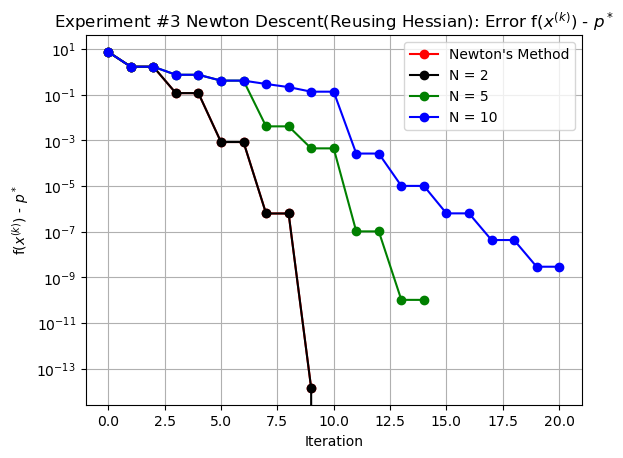

In [292]:
#Plot distance to optimal function value throughout Newton's Method for N = 1, 2, 5, 10
reused_newton_descent_gap_to_optimal_N1 = reused_newton_descent_function_values_N1 - p_star_seed2
reused_newton_descent_gap_to_optimal_N2 = reused_newton_descent_function_values_N2 - p_star_seed2
reused_newton_descent_gap_to_optimal_N5 = reused_newton_descent_function_values_N5 - p_star_seed2
reused_newton_descent_gap_to_optimal_N10 = reused_newton_descent_function_values_N10 - p_star_seed2

reused_newton_descent_gap_to_optimal_N1 = reused_newton_descent_gap_to_optimal_N1[:-1]

# print(f"Gap to Optimal for N = 1: {reused_newton_descent_gap_to_optimal_N1}")
# print(f"Gap to Optimal for N = 2: {reused_newton_descent_gap_to_optimal_N2}")
# print(f"Gap to Optimal for N = 5: {reused_newton_descent_gap_to_optimal_N5}")
# print(f"Gap to Optimal for N = 10: {reused_newton_descent_gap_to_optimal_N10}")

line1, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N1))), reused_newton_descent_gap_to_optimal_N1, marker='o', color='red', linestyle='-')
line2, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N2))), reused_newton_descent_gap_to_optimal_N2, marker='o', color='black', linestyle='-')
line3, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N5))), reused_newton_descent_gap_to_optimal_N5, marker='o', color='green', linestyle='-')
line4, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N10))), reused_newton_descent_gap_to_optimal_N10, marker='o', color='blue', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #3 Newton Descent(Reusing Hessian): Error f($x^{(k)}$) - $p^*$')
plt.legend(handles=[line1, line2, line3, line4], labels=['Newton\'s Method', 'N = 2', 'N = 5', 'N = 10'])
plt.grid(True)
plt.show()

Observations: 
- As N increases, the speed of convergence decreases

## 9.31 (b)

### Experiment #1

In [293]:
#Global Variables
n = 10
m = 20
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [294]:
#Run Newton's Method where Hessian is approximated by its diagonal
diagonal_newton_descent_iterates, diagonal_newton_descent_function_values, diagonal_newton_descent_alpha_values = diagonal_newton_descent(f, f_gradient, f_diagonal_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 11.30563226978405, Newton Parameter: 6.0990022951874066
Iteration: 2, Max of A @ x: 0.38723852644957024, Max of x^2: 0.13420052036689464, Current Function Value(Beginning of Iteration): -3.6892446711149, Norm of Gradient: 4.8572219427428545, Newton Parameter: 1.4403795403514927
Iteration: 3, Max of A @ x: 0.3872385222075463, Max of x^2: 0.1342005224886311, Current Function Value(Beginning of Iteration): -3.689244692578228, Norm of Gradient: 4.8572218925512045, Newton Parameter: 1.4403795144667861
Iteration: 4, Max of A @ x: 0.2868895906516955, Max of x^2: 0.3143562299887707, Current Function Value(Beginning of Iteration): -4.645448405222783, Norm of Gradient: 3.7729312485286464, Newton Parameter: 0.8052451996851903
Iteration: 5, Max of A @ x: 0.28688959015772936, Max of x^2: 0.3143562301527316, Current Function Value(Beginning of Iteration): -4.645448411222328, Norm

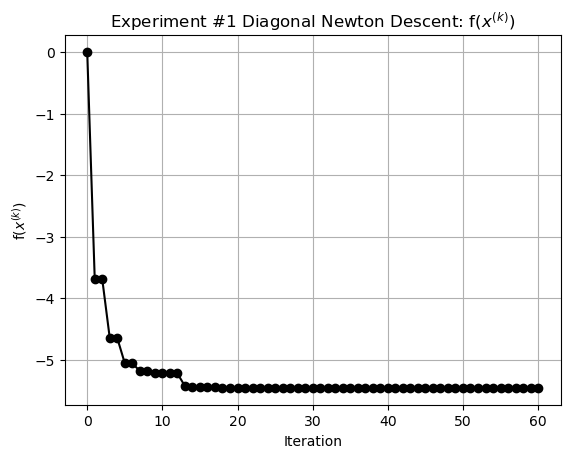

In [295]:
#Plot function values throughout Newton's Method where the Hessian is replaced by its diagonal
plt.plot(list(range(len(diagonal_newton_descent_function_values))), diagonal_newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #1 Diagonal Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

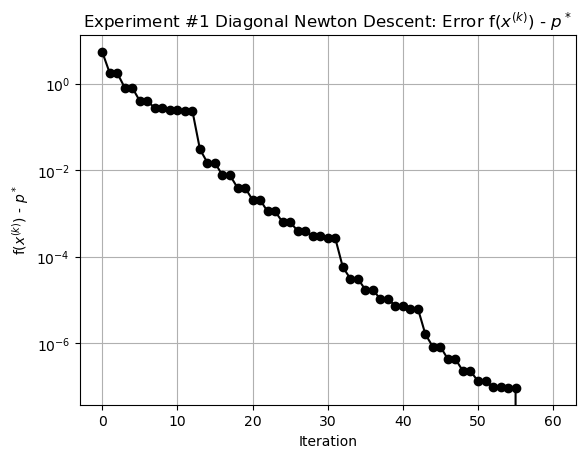

In [296]:
#Plot distance to optimal function value throughout Newton's Method where the Hessian is replaced by its diagonal
diagonal_newton_descent_gap_to_optimal = diagonal_newton_descent_function_values - p_star_seed0
plt.plot(list(range(len(diagonal_newton_descent_gap_to_optimal))), diagonal_newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #1 Diagonal Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

### Experiment #2

In [297]:
#Global Variables
n = 10
m = 20
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [298]:
#Run Newton's Method where Hessian is approximated by its diagonal
diagonal_newton_descent_iterates, diagonal_newton_descent_function_values, diagonal_newton_descent_alpha_values = diagonal_newton_descent(f, f_gradient, f_diagonal_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 19.153454079329176, Newton Parameter: 19.126866578295907
Iteration: 2, Max of A @ x: 0.7432762924067442, Max of x^2: 0.21827812066830407, Current Function Value(Beginning of Iteration): -9.990582856793212, Norm of Gradient: 6.285128734815801, Newton Parameter: 2.8656950388572406
Iteration: 3, Max of A @ x: 0.7432762881791166, Max of x^2: 0.21827812198973165, Current Function Value(Beginning of Iteration): -9.990582899495397, Norm of Gradient: 6.285128631997519, Newton Parameter: 2.865694995238005
Iteration: 4, Max of A @ x: 0.4595650125735368, Max of x^2: 0.4332791758261503, Current Function Value(Beginning of Iteration): -11.652732737998718, Norm of Gradient: 3.585967965711528, Newton Parameter: 1.2999619385508077
Iteration: 5, Max of A @ x: 0.4595650238833266, Max of x^2: 0.43327917531994176, Current Function Value(Beginning of Iteration): -11.652732776740605, Nor

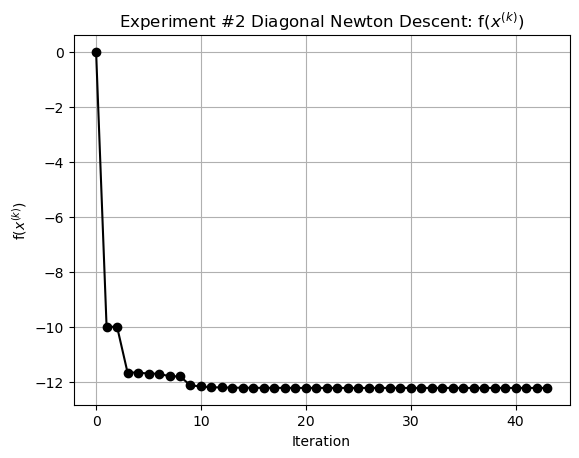

In [299]:
#Plot function values throughout Newton's Method where the Hessian is replaced by its diagonal
plt.plot(list(range(len(diagonal_newton_descent_function_values))), diagonal_newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #2 Diagonal Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

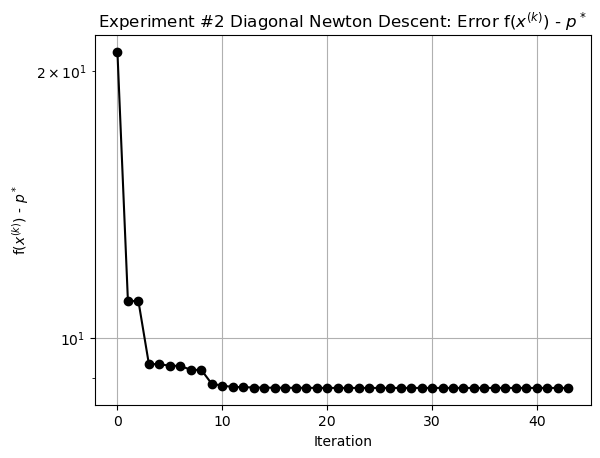

In [300]:
#Plot distance to optimal function value throughout Newton's Method where the Hessian is replaced by its diagonal
diagonal_newton_descent_gap_to_optimal = diagonal_newton_descent_function_values - p_star_seed1
plt.plot(list(range(len(diagonal_newton_descent_gap_to_optimal))), diagonal_newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #2 Diagonal Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

### Experiment #3

In [301]:
#Global Variables
n = 10
m = 20
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [302]:
#Run Newton's Method where Hessian is approximated by its diagonal
diagonal_newton_descent_iterates, diagonal_newton_descent_function_values, diagonal_newton_descent_alpha_values = diagonal_newton_descent(f, f_gradient, f_diagonal_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 20.738329804807222, Newton Parameter: 16.17323086521845
Iteration: 2, Max of A @ x: 0.6642971664839591, Max of x^2: 0.0672147632083264, Current Function Value(Beginning of Iteration): -4.796877072368903, Norm of Gradient: 8.391334859725674, Newton Parameter: 3.024537262370024
Iteration: 3, Max of A @ x: 0.5937183552352128, Max of x^2: 0.2727447254457215, Current Function Value(Beginning of Iteration): -6.686848273578867, Norm of Gradient: 4.169958603602463, Newton Parameter: 1.0408451251277817
Iteration: 4, Max of A @ x: 0.5937183552268139, Max of x^2: 0.27274472564508484, Current Function Value(Beginning of Iteration): -6.686848274548229, Norm of Gradient: 4.169958597583617, Newton Parameter: 1.0408451218579147
Iteration: 5, Max of A @ x: 0.683688823041704, Max of x^2: 0.39027769914335464, Current Function Value(Beginning of Iteration): -6.98344746629841, Norm of G

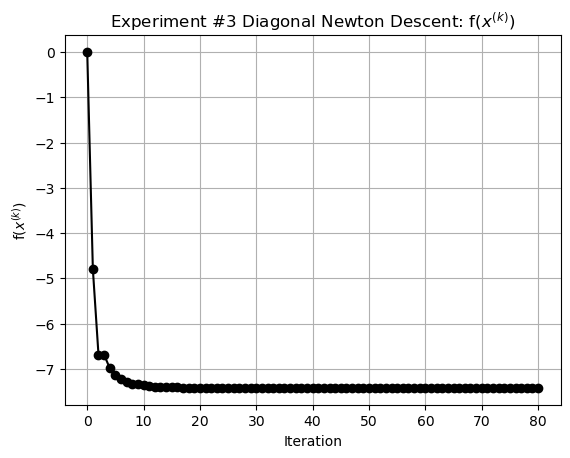

In [303]:
#Plot function values throughout Newton's Method where the Hessian is replaced by its diagonal
plt.plot(list(range(len(diagonal_newton_descent_function_values))), diagonal_newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #3 Diagonal Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

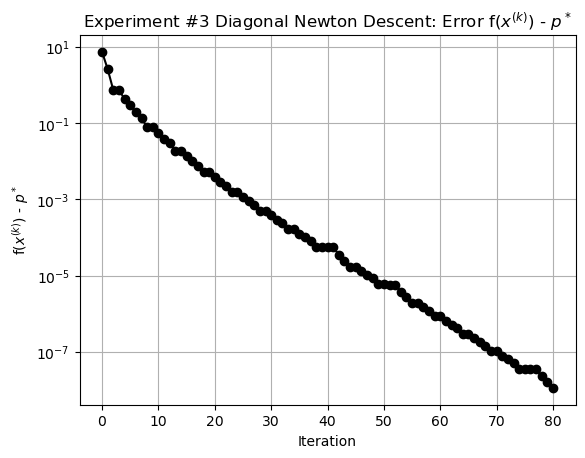

In [304]:
#Plot distance to optimal function value throughout Newton's Method where the Hessian is replaced by its diagonal
diagonal_newton_descent_gap_to_optimal = diagonal_newton_descent_function_values - p_star_seed2
plt.plot(list(range(len(diagonal_newton_descent_gap_to_optimal))), diagonal_newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #3 Diagonal Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

Conclusions for 9.31 (b): When we are using the Diagonal Approximation of the Hessian, the convergence behavior strongly resembles that of the Gradient Descent Method